# Defected nuts

Solution author: Asandei Stefan-Alexandru

In [62]:
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from PIL import Image
import pandas as pd
import numpy as np
import base64
import torch
import torchvision.models as models
from torch.nn import functional as F
from scipy.ndimage import gaussian_filter

In [63]:
root_path = "/home/stefan/ioai-prep/kits/the-defected-nuts-aicc-round-1/data"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load ResNet18 Feature Extractor

In [64]:
# Load pretrained ResNet18
resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
resnet = resnet.to(device)
resnet.eval()

# Use layer2 (higher resolution than layer3)
feature_extractor = torch.nn.Sequential(
    *list(resnet.children())[:-3]  # Remove layer3, layer4, avgpool, fc
)
feature_extractor.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

# Extract Features from Training Images

In [65]:
train_dir = Path(f"{root_path}/train")
train_paths = sorted(train_dir.glob("*.png"), key=lambda x: int(x.stem))

train_features = []

for p in tqdm(train_paths, desc="Extracting training features"):
    img = Image.open(p).convert("RGB")
    img_tensor = torch.from_numpy(np.array(img)).float().to(device)
    img_tensor = img_tensor.permute(2, 0, 1).unsqueeze(0) / 255.0

    with torch.no_grad():
        features = feature_extractor(img_tensor)

    train_features.append(features.cpu())

train_features = torch.cat(train_features, dim=0)
train_features.shape

Extracting training features: 100%|██████████| 431/431 [00:17<00:00, 25.10it/s]


torch.Size([431, 256, 64, 64])

In [66]:
mean_features = train_features.mean(dim=0, keepdim=True)

# Process Test Images

In [67]:
test_dir = Path(f"{root_path}/test")
test_paths = sorted(test_dir.glob("*.png"), key=lambda x: int(x.stem))

In [68]:
anomaly_maps = []

for p in tqdm(test_paths, desc="Processing test images"):
    img = Image.open(p).convert("RGB")
    img_tensor = torch.from_numpy(np.array(img)).float().to(device)
    img_tensor = img_tensor.permute(2, 0, 1).unsqueeze(0) / 255.0

    with torch.no_grad():
        features = feature_extractor(img_tensor).cpu()

    # Simple L2 distance from mean (no z-score)
    anomaly_score = torch.norm(
        features - mean_features, dim=1, keepdim=True
    )  # (1, 1, H, W)

    # Upsample to 1024x1024
    anomaly_score = F.interpolate(
        anomaly_score, size=(1024, 1024), mode="bilinear", align_corners=False
    )

    anomaly_score = anomaly_score.squeeze().cpu().numpy()

    # Light smoothing
    anomaly_score = gaussian_filter(anomaly_score, sigma=1.5)

    anomaly_maps.append(anomaly_score)

anomaly_maps = np.array(anomaly_maps)
anomaly_maps.shape

Processing test images: 100%|██████████| 70/70 [00:04<00:00, 14.50it/s]


(70, 1024, 1024)

In [69]:
# Normalize across ALL test images
global_min = anomaly_maps.min()
global_max = anomaly_maps.max()

anomaly_maps = (anomaly_maps - global_min) / (global_max - global_min + 1e-6)
anomaly_maps = (anomaly_maps * 255).astype(np.uint8)

print(f"Min: {anomaly_maps.min()}, Max: {anomaly_maps.max()}")

Min: 0, Max: 254


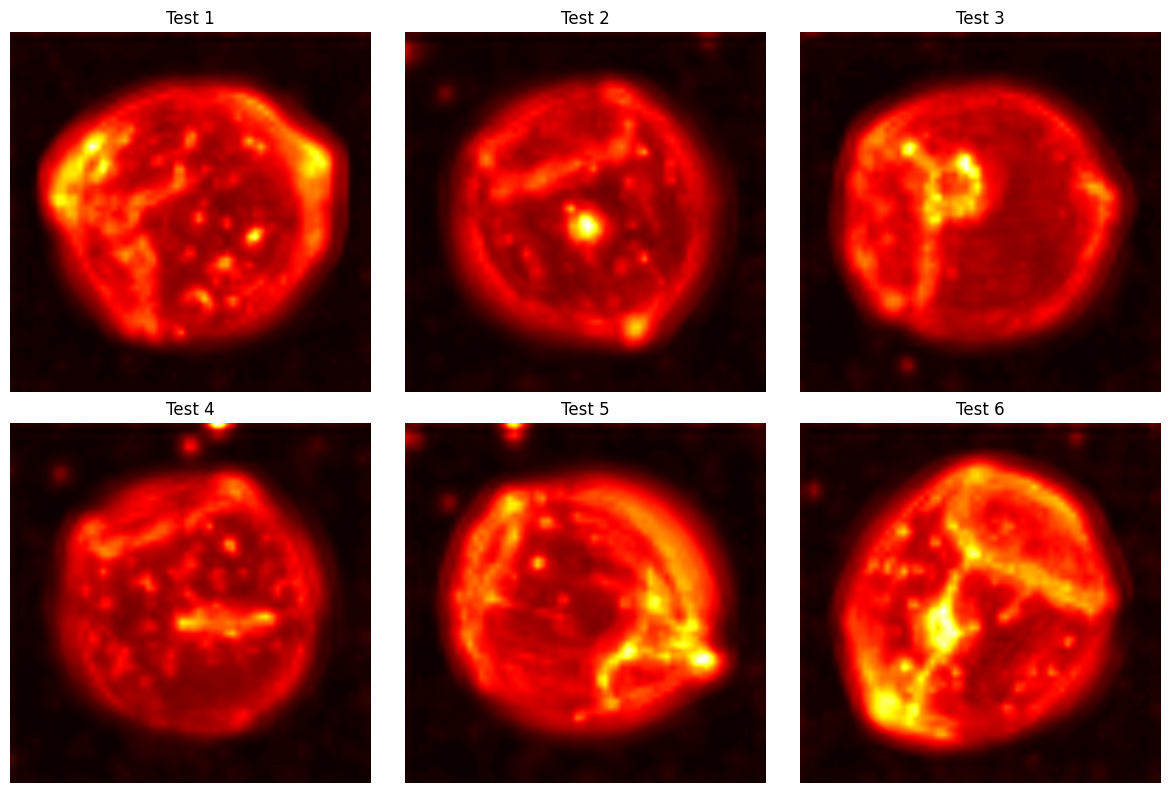

In [70]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for i in range(6):
    axes[i // 3, i % 3].imshow(anomaly_maps[i], cmap="hot")
    axes[i // 3, i % 3].set_title(f"Test {i+1}")
    axes[i // 3, i % 3].axis("off")
plt.tight_layout()
plt.show()

# Submission

In [71]:
submission = pd.DataFrame(columns=["data"])

for i, anomaly_map in enumerate(tqdm(anomaly_maps, desc="Encoding")):
    submission.loc[i] = base64.b85encode(anomaly_map.tobytes()).decode("ascii")

submission = submission.reset_index()
submission.columns = ["id", "data"]

submission.head()

Encoding: 100%|██████████| 70/70 [00:05<00:00, 12.09it/s]


,id,data
0,0,1_lNO1_lNO1_lQQ2L}fS2L}fS2nYxW2nYxW2nYxW2nYxW2...
1,1,4-XFy4-XFy4-XFz5D*X$5D^g(5fKp)5fKp)5fKm&5D*X#4...
2,2,5fKp)5fKp)5fTy;6BHB`78Vy57#SHE8X6iJ8X6iJ8X6iJ8...
3,3,1_lNO1_lNO1_lNO1_lNO1_lNO1_lNO1_lNP2L}fS2L}iU2...
4,4,6B82?6B82?6BHB_6%`d078Vv47Z(^97#J8B7#J597Z(>77...


In [72]:
submission.to_csv(f"{root_path}/submission.csv", index=False)